In [1]:
import igraph as ig
import pandas as pd
import itertools
from collections import Counter

# Graph-Based Approach to Popularity and Recommendations


Aside from using `HashTag Count` to measure hashtag popularity, we can apply methods from `Graph Theory`.

In this approach we will create an **(undirected) Graph where:**

- The hashtags are nodes
- The edges (with weights) represent how often two hashtags appear together in all posts (and reblogs)
  
We can then use `centrality measures` (metrics that show how important a node is in a graph) to evaluate hashtag popularity. 

These centrality measures can also help us group similar hashtags based on their connections.

In [2]:
# utility functions
def create_hashtag_pairs(hashtags):
    tag_pairs = []
    for tag_list in hashtags:
        if len(tag_list) > 1:  # Only consider rows that have more than 1 hashtag
            tag_pairs.extend(itertools.combinations(tag_list, 2))
    return tag_pairs


def count_hashtag_occurrences(hashtags):
    all_hashtags = [tag for sublist in hashtags for tag in sublist]
    return Counter(all_hashtags)


def split_tags(tags_str):
    if tags_str:
        return [tag.strip().lower() for tag in tags_str.split(",") if tag.strip()]

    return []

### Prepare Dataset

In [3]:
df = pd.read_csv("../data/full_dataset.csv", usecols=["root_tags", "tags"])
df["root_tags"] = df["root_tags"].fillna("")
df["tags"] = df["tags"].fillna("")

# Concatenating both root_tags and reblogged tags to get all co-occurrences as edges between a graph.
tags_series = (
    pd.concat([df["root_tags"], df["tags"]]).apply(split_tags).reset_index(drop=True)
)
tags_series

0          [sadie sink, sadiesinkedit, femaledaily, daily...
1                                                         []
2                                                         []
3          [alchemy of souls, alchemy of souls: light and...
4          [manila mikey, manjiro sano, tokyo manji gang,...
                                 ...                        
3529079                                              [mp100]
3529080    [the way his expression changes😂, doctor who, ...
3529081    [we did a thing, harringrove, teacher!steve, k...
3529082         [what the hell am i gonna do when it’s done]
3529083              [other people’s art, quilting, turtles]
Length: 3529084, dtype: object

In [4]:
pairs = create_hashtag_pairs(tags_series)
hashtag_counts = count_hashtag_occurrences(tags_series)

In [5]:
len(pairs), len(hashtag_counts)

(70876200, 2282228)

In [6]:
# Count the pairs of the tags
pair_counts = Counter(pairs)
len(pair_counts)

22763178

In [7]:
# Count the proportion of edge weights
edges_distribution = (
    pd.Series(pair_counts.values()).value_counts(normalize=False).reset_index()
)
edges_distribution.columns = ["edge_weight", "count"]
edges_distribution["count_prc"] = (
    edges_distribution["count"] / edges_distribution["count"].sum()
)
edges_distribution["count_prc_cumulative"] = edges_distribution["count_prc"].cumsum()
edges_distribution.head(15)

# So over 95 % of the connections are co-occurrences of tags with size up to 8.

,edge_weight,count,count_prc,count_prc_cumulative
0,1,15732948,0.691158,0.691158
1,2,2850155,0.125209,0.816367
2,3,1204781,0.052927,0.869294
3,4,683513,0.030027,0.899321
4,5,433080,0.019025,0.918346
5,6,304810,0.013390,0.931737
6,7,219931,0.009662,0.941398
7,8,170690,0.007499,0.948897
8,9,132737,0.005831,0.954728
9,10,110694,0.004863,0.959591


In [8]:
# So we want to keep a smaller graph that has stronger signals.
min_threshold = 20
filtered_pair_counts = {i: j for i, j in pair_counts.items() if j > min_threshold}
len(filtered_pair_counts)

426222

In [9]:
# Build the graph in igraph
G = ig.Graph()

# Add vertices (hashtags)
G.add_vertices(list(set([tag for pair in filtered_pair_counts.keys() for tag in pair])))

# Add edges (co-occurrences between hashtags)
edges = [(pair[0], pair[1]) for pair in filtered_pair_counts.keys()]
G.add_edges(edges)

# We also we add weights being the total count of the co-occurrences
G.es["weight"] = [count for count in filtered_pair_counts.values()]

# Now we will add the number of appearances as a node attribute
G.vs["tag_count"] = [hashtag_counts.get(node["name"], 0) for node in G.vs]

## Centrality Measures

- `Degree Centrality (basic popularity)`: Measures the number of direct connections a node (hashtag) has, representing its basic popularity.
- `Weighted Degree Centrality`: Shows the strength of connections by considering the weights (# of co-occurrences) of the edges, not just the number of connections.
- `Betweenness Centrality`: Shows how often a node (hashtag) appears on the shortest paths between other nodes, indicating its role in connecting different groups.
- `Eigenvector Centrality`: Measures a node's influence based on the importance of its neighbors, giving more weight to nodes connected to other influential nodes.
- `Closeness Centrality`: Represents how close a node is to all other nodes in the graph, based on the shortest paths, showing how easily a node can reach others.

In [10]:
# Degree centrality (basic popularity)
degrees = G.degree()
# Weighted degree centrality
weighted_degrees = G.strength(weights=G.es["weight"])
# Betweenness centrality
betweenness = G.betweenness()
# Eigenvector centrality
eigenvector_centrality = G.eigenvector_centrality()
# Closeness centrality
closeness = G.closeness()

In [11]:
centralities = []
for i in zip(
    degrees, weighted_degrees, betweenness, eigenvector_centrality, closeness, G.vs
):
    centralities.append(
        {
            "tag": i[5]["name"],
            "tag_count": i[5]["tag_count"],
            "node_degree": i[0],
            "weighted_degree": i[1],
            "betweenness": i[2],
            "eigenvector": i[3],
            "closeness": i[4],
        }
    )

centralities = pd.DataFrame(centralities)
centralities

,tag,tag_count,node_degree,weighted_degree,betweenness,eigenvector,closeness
0,this post got away from me a little,28,1,28.0,0.000000,0.000497,0.263673
1,furry dog,25,29,685.0,0.097044,0.000723,0.256141
2,cfsbf,81,4,144.0,0.000000,0.000000,0.545455
3,fut-175,26,29,754.0,0.000000,0.000000,0.362253
4,fluff,1416,50,2004.0,258607.008562,0.010338,0.325750
...,...,...,...,...,...,...,...
47429,footfetish,87,7,305.0,1.200000,0.000018,0.223097
47430,omnivore,60,8,289.0,0.000000,0.000308,0.258613
47431,emricasan,40,29,1160.0,0.000000,0.000000,1.000000
47432,griffith,116,3,130.0,0.000000,0.000041,0.242887


In [12]:
centralities.sort_values("tag_count", ascending=False)

,tag,tag_count,node_degree,weighted_degree,betweenness,eigenvector,closeness
14949,art,110696,4754,415943.0,1.493694e+08,0.460062,0.453987
5890,my art,77000,4597,355117.0,1.447908e+08,0.360377,0.443059
12985,fanart,53664,2998,242434.0,6.859590e+07,0.304874,0.428706
10338,*,32919,2963,304843.0,5.620573e+07,1.000000,0.408954
20309,mine,32794,2410,156353.0,9.085915e+07,0.741296,0.437400
...,...,...,...,...,...,...,...
45035,handphone,12,1,24.0,0.000000e+00,0.000011,0.227909
42267,tebal,12,1,24.0,0.000000e+00,0.000016,0.228275
13722,nocontext.sag,12,1,24.0,0.000000e+00,0.000009,0.227981
36635,เบทฟิกโอจี,11,1,22.0,0.000000e+00,0.000000,0.511111


Now, given the centralities we may perform **clustering on the Nodes (hashtags)** in order to define `popularity clusters`.

This method may have some **drawbacks** though. 

Clustering a hashtag that is not yet in the graph can be challenging, as centrality measures **rely on its existing connections**. We can't just assign a new Hashtag to get the cluster ID unless you connect it to the graph.

One way we could handle this is to **estimate closest Nodes** based on the new hashtag's similarity to existing ones (e.g., using word embeddings or contextual analysis). Then we can use the nearest neighbors that appear on the Graph and take an aggregation (mean) of their centrality measures. This way we would assign the new Hashtag into the cluster.

Note: What we also need to do is every few days enhance the Graph and re-calculate the centralities. Then run again the clustering algorithm. 


<Axes: >

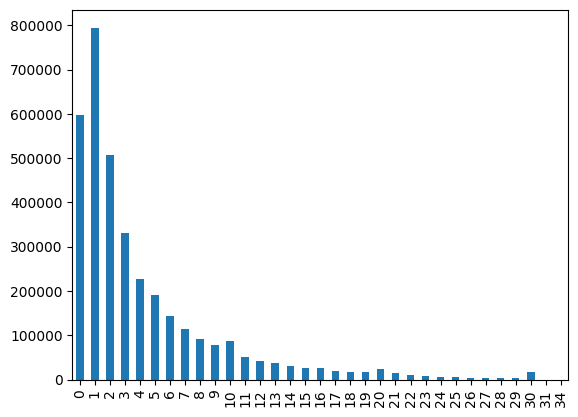

In [13]:
tags_series.apply(len).value_counts().sort_index().plot(kind="bar")

In [14]:
tags_series.apply(len).value_counts(normalize=True).sort_index().cumsum()

0     0.169434
1     0.394778
2     0.538423
3     0.632507
4     0.696786
5     0.750662
6     0.791589
7     0.823672
8     0.849850
9     0.872068
10    0.896692
11    0.911213
12    0.923325
13    0.934159
14    0.942794
15    0.949920
16    0.957373
17    0.962966
18    0.967951
19    0.972905
20    0.979794
21    0.983783
22    0.986452
23    0.988542
24    0.990038
25    0.991386
26    0.992524
27    0.993614
28    0.994499
29    0.995428
30    0.999996
31    0.999996
34    1.000000
Name: proportion, dtype: float64

In [15]:
# Now we'll find all maximal cliques in the graph of size between 3 and 5
maximal_cliques = G.cliques(min=3, max=5)
print(f"Number of maximal cliques: {len(maximal_cliques)}")

Number of maximal cliques: 100786106


In [16]:
# We can also find the communities in the graph
communities = G.community_multilevel(weights=G.es["weight"])

In [17]:
len(communities)

1425

In [18]:
# Assign each node to a community
community_assignments = communities.membership

In [19]:
# Add the community assignments to the graph
G.vs["community"] = community_assignments

In [20]:
# Now we can see the distribution of the communities
community_distribution = pd.Series(community_assignments).value_counts(normalize=True)

In [23]:
community_distribution

1       0.105684
10      0.096893
6       0.079099
24      0.046570
7       0.037505
          ...   
859     0.000042
861     0.000042
866     0.000042
868     0.000042
1424    0.000042
Name: proportion, Length: 1425, dtype: float64